In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import glob
from wordcloud import WordCloud
import re
from functools import partial
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
path_to_dirty_message = "dirty_data/messages/inbox"
file_name = "dai2023_mursz7zwfw" #tuesunrerharry_52t9lipw2q" #dai2023_mursz7zwfw #3bgs_4bl163p6gg short group #antoinerecioandrades_17vi2uw8vg short 1to1 conv #charlottedebras_ggrpv0yi6q

path_to_clean_message = "cleanData"
paths_to_files = glob.glob(path_to_clean_message + "/" + file_name + "/" + "message_*.json")
#paths_to_files = glob.glob(path_to_dirty_message + "/" + file_name + "/" + "message_*.json")

In [3]:
def get_dom(dt):
    return dt.day
def get_dow(dt):
    return dt.weekday()
def get_hour(dt):
    return dt.hour
def count_rows(rows):
    return len(rows)
def scaled_count_rows(rows):
    return np.log(len(rows))**2.4
def light_scaled_count_rows(rows):
    return np.log(len(rows))**1.8
def loadFacebookJson(filePath):
    fix_mojibake_escapes = partial(
     re.compile(rb'\\u00([\da-f]{2})').sub,
     lambda m: bytes.fromhex(m.group(1).decode()))

    with open(filePath, 'rb') as binary_data:
        repaired = fix_mojibake_escapes(binary_data.read())
    return json.loads(repaired.decode('utf8'))

posWord = {'😇','😘','🙂','💃','😏','🥰','😋','🤣','😍','😁','😆','❤️','😉','😂','merci','cool','super','wouaw','j\'adore','bien','bon','chaud','intéressé','craque','ahah','hihi','haha','ahahah','hahaha','excellente','saucé','perfect','mdr','enormous','epic','hahahaha'}
negWord = {'😒','😠','🥺','😬','😤','🙄','🥵','😥','😰','hélas','zoo','ridicule','honte','honteux','fous','putain','merde','relou','flemme','mauvaise','déteste','mais','triste'}

def getEmotion(message,posWord,negWord):
    scallingFactorNeutral = 0.1
    message = message.split(" ")
    lenMes = len(message)
    cptDict = {'Positive':0,'Negative': 0, 'Neutral':0}
    for word in message:
        if word.lower() in posWord:
            cptDict['Positive'] = cptDict['Positive'] + 1
        elif word.lower() in negWord:
            cptDict['Negative'] = cptDict['Negative'] + 1
        else:
            cptDict['Neutral'] = cptDict['Neutral'] + 1
            
    cptDict['Neutral'] = 1*scallingFactorNeutral*cptDict['Neutral']/(lenMes)
    return max(cptDict, key=cptDict.get)

def getDfEmotion(row,posWord,negWord):
    if row.type == 'text':
        return getEmotion(row.message,posWord,negWord)
    else:
        return None


In [4]:
df = pd.DataFrame(columns={"sender","message","time","messageWordLength","messageCharacterLength","type"})
dfReactions = pd.DataFrame(columns={"reaction","sender","messageIndex","messageSender"})
threadInfo = {}

cpt = 0

for filePath in paths_to_files:
    data = loadFacebookJson(filePath)
    if cpt == 0:
        
        nbParticipants = len(data['participants'])
        nbMessages = len(data['messages'])
        title = data['title']
        threadType = data['thread_type']
        threadInfo = {'nbParticipants': nbParticipants,'nbMessages': nbMessages,'title':title,'threadType':threadType}             

    for index,row in enumerate(data['messages']):
        
        messageType = row['type']
        
        if messageType == 'Generic':
            messageCharacterLength = 0
            messageWordLength = 0
            content = None
            timestamp = row['timestamp_ms']
            mType = "text"
            
            if 'content' in row.keys():
                content = row["content"]
                messageCharacterLength = len(content)
                messageWordLength = len(content.split(" "))
            elif 'photos' in row.keys():
                mType = "photo"
            elif 'videos' in row.keys():
                mType = 'video'
            elif 'audio_files' in row.keys():
                mType = 'audio'
            elif 'gifs' in row.keys():
                mType = 'gif'
            elif 'sticker' in row.keys():
                mType = 'sticker'
            else:
                mType = 'deleted'

            df = df.append({'sender':row['sender_name'],"messageWordLength":messageWordLength,"messageCharacterLength":messageCharacterLength,"time": timestamp,"message":content,"type":mType},ignore_index=True)
        if 'reactions' in row.keys():
            for reaction in row['reactions']:
                dfReactions = dfReactions.append({"reaction":reaction['reaction'],"sender":reaction['actor'],"messageIndex":index,"messageSender":row['sender_name']},ignore_index=True)
    cpt +=1
    
df["time"] = pd.to_datetime(df['time'],unit='ms')
df["hour"] = df["time"].map(get_hour)
df["dow"] = df["time"].map(get_dow)
df["dom"] = df["time"].map(get_dom)
df['date'] = df["time"].dt.date
df['messageWordLength'] = df['messageWordLength'].astype(int)
df['messageCharacterLength'] = df['messageCharacterLength'].astype(int)
df['emotion'] = df[['message','type']].apply(lambda x : getDfEmotion(x,posWord,negWord),axis=1)

threadInfo['threadLifetime'] = (df.loc[0,"time"]-df.loc[df.shape[0]-1,"time"])/ pd.Timedelta(weeks=1)
threadInfo['nbReaction'] = dfReactions.shape[0]
df = df.reindex(index=df.index[::-1])
df = df.reset_index()

In [5]:
def getMinutesDuration(time1,time2):
    return (time2-time1) / pd.Timedelta(minutes=1)


#df = df.reindex(index=df.index[::-1])

dfGrouped = pd.DataFrame()
currentSender = df.loc[0,'sender']
selfResponseTimeThreshold = 30
startTime = df.loc[0,'time']
endTime = df.loc[0,'time']
isSelfResponse = False
currentNbMessages = 0
cpt = 0
responseTime = 0

for index,row in df.iterrows():
    if row['sender'] == currentSender and getMinutesDuration(endTime,row['time']) <= selfResponseTimeThreshold:
        #Updating Duration
        currentNbMessages += 1
        endTime = row['time']
        
    else:
        #Updating the DataFrame
        dfGrouped = dfGrouped.append({'sender':currentSender,'startTime':startTime,'endTime':endTime,'responseTime': responseTime ,'isSelfResponse':isSelfResponse,'nbMessages':currentNbMessages},ignore_index=True)
        
        #Reseting info
        responseTime = getMinutesDuration(endTime,row["time"])
        isSelfResponse = row['sender'] == currentSender
        currentSender = row['sender']
        startTime = row['time']
        endTime = row['time']
        currentNbMessages = 1
        

In [6]:
dfGrouped.head()

,endTime,isSelfResponse,nbMessages,responseTime,sender,startTime
0,2021-08-23 09:53:43.386,0.0,2.0,0.000000,Maximilien Dufau,2021-08-23 09:53:20.593
1,2021-08-23 09:56:21.300,0.0,1.0,2.631900,Charlotte Mauvezin,2021-08-23 09:56:21.300
2,2021-08-23 09:58:00.621,0.0,1.0,1.655350,Pascal Huang,2021-08-23 09:58:00.621
3,2021-08-23 09:58:24.400,0.0,1.0,0.396317,Kenza Tazi,2021-08-23 09:58:24.400
4,2021-08-23 10:01:28.945,0.0,1.0,3.075750,Vincent Tran,2021-08-23 10:01:28.945


In [7]:
dfGrouped.nbMessages.describe()

count    860.000000
mean       1.358140
std        0.744161
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: nbMessages, dtype: float64

In [8]:
dfGrouped.groupby('sender').median()

,isSelfResponse,nbMessages,responseTime
sender,,,
Alexandre Messika,0.0,1.0,1.943692
Amélie Jond,0.0,1.0,0.780100
Anaïs Tonlop,0.0,1.0,0.219175
Anthony RJ,0.0,1.0,1.607433
Armand Drouineau,0.0,1.0,83.424483
Benoit Cimetiere,0.0,1.0,0.363908
Benoit Claudic,0.0,1.0,0.411717
Charlotte Mauvezin,0.0,1.0,0.399183
Elliott Joliman,0.0,1.0,0.398650


In [9]:
dfGrouped[dfGrouped.nbMessages==2]

,endTime,isSelfResponse,nbMessages,responseTime,sender,startTime
0,2021-08-23 09:53:43.386,0.0,2.0,0.000000,Maximilien Dufau,2021-08-23 09:53:20.593
13,2021-08-23 11:51:35.337,0.0,2.0,0.984000,Paul Meignan,2021-08-23 11:51:28.626
37,2021-08-24 06:12:38.872,0.0,2.0,0.633217,Kenza Tazi,2021-08-24 06:12:16.144
46,2021-08-24 06:24:27.704,0.0,2.0,0.886533,Kétessar Tan,2021-08-24 06:24:04.028
50,2021-08-24 06:29:48.452,0.0,2.0,0.430933,Vincent Tran,2021-08-24 06:29:35.342
...,...,...,...,...,...,...
830,2021-10-11 21:05:18.410,0.0,2.0,0.249517,Matth Han,2021-10-11 21:01:12.785
834,2021-10-13 21:02:43.561,0.0,2.0,0.678217,Charlotte Mauvezin,2021-10-13 21:02:13.135
838,2021-10-15 14:50:53.960,0.0,2.0,1416.941867,Vincent Tran,2021-10-15 14:50:34.841
843,2021-10-15 14:53:10.037,0.0,2.0,0.088150,Kenza Tazi,2021-10-15 14:52:55.709


In [10]:
dfGrouped[dfGrouped.isSelfResponse != 0].responseTime.describe()

count      9.000000
mean     190.318846
std      128.398964
min       66.522133
25%       87.571133
50%      134.381533
75%      253.486117
max      399.925900
Name: responseTime, dtype: float64

In [11]:
dfGrouped[dfGrouped.isSelfResponse != 0].shape[0]

9

In [12]:
dfGrouped.responseTime.describe()

count     860.000000
mean       92.158913
std       360.312865
min         0.000000
25%         0.312900
50%         1.153892
75%        14.070700
max      4295.172417
Name: responseTime, dtype: float64

In [13]:
dfGrouped.groupby('sender').median()

,isSelfResponse,nbMessages,responseTime
sender,,,
Alexandre Messika,0.0,1.0,1.943692
Amélie Jond,0.0,1.0,0.780100
Anaïs Tonlop,0.0,1.0,0.219175
Anthony RJ,0.0,1.0,1.607433
Armand Drouineau,0.0,1.0,83.424483
Benoit Cimetiere,0.0,1.0,0.363908
Benoit Claudic,0.0,1.0,0.411717
Charlotte Mauvezin,0.0,1.0,0.399183
Elliott Joliman,0.0,1.0,0.398650


0.9894166666666667

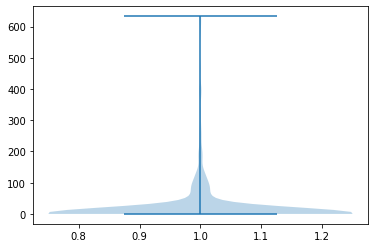

In [14]:
a = dfGrouped.responseTime
a = a[a <= a.quantile(0.95)]
plt.violinplot(a)
a.median()

{'bodies': [<matplotlib.collections.PolyCollection at 0x18ddbfe6fd0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x18ddbfe6f70>,
 'cmins': <matplotlib.collections.LineCollection at 0x18ddbff6520>,
 'cbars': <matplotlib.collections.LineCollection at 0x18ddbff6850>}

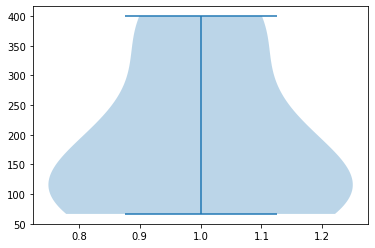

In [15]:
plt.violinplot(dfGrouped[dfGrouped.isSelfResponse != 0].responseTime.to_list())

In [16]:
cpt = 1
for index,row in df.iterrows():
    print(index)
    cpt+=1
    if (cpt == 3):
        break

0
1


In [17]:
dfGrouped[dfGrouped.isSelfResponse != 0].shape[0]/df.shape[0]

0.007698887938408896

In [18]:
dfGrouped

,endTime,isSelfResponse,nbMessages,responseTime,sender,startTime
0,2021-08-23 09:53:43.386,0.0,2.0,0.000000,Maximilien Dufau,2021-08-23 09:53:20.593
1,2021-08-23 09:56:21.300,0.0,1.0,2.631900,Charlotte Mauvezin,2021-08-23 09:56:21.300
2,2021-08-23 09:58:00.621,0.0,1.0,1.655350,Pascal Huang,2021-08-23 09:58:00.621
3,2021-08-23 09:58:24.400,0.0,1.0,0.396317,Kenza Tazi,2021-08-23 09:58:24.400
4,2021-08-23 10:01:28.945,0.0,1.0,3.075750,Vincent Tran,2021-08-23 10:01:28.945
...,...,...,...,...,...,...
855,2021-10-17 14:02:09.805,0.0,1.0,41.498883,Moise Iloo,2021-10-17 14:02:09.805
856,2021-10-17 14:58:10.777,0.0,1.0,56.016200,Vincent Tran,2021-10-17 14:58:10.777
857,2021-10-17 15:07:40.702,0.0,1.0,9.498750,Sixtine Brisard,2021-10-17 15:07:40.702
858,2021-10-17 15:08:52.145,0.0,1.0,1.190717,Matth Han,2021-10-17 15:08:52.145


In [19]:
df1 = dfReactions.groupby(['messageSender','reaction']).count()
df1['reaction'] = df1.index.map(lambda x: x[1])
df1.index = df1.index.map(lambda x:x[0])
df1.shape

(77, 3)

In [20]:
df2 = df[['sender','time']].groupby('sender',as_index=False).count()
df1['reactionRatio'] = df1.apply(lambda x: x.messageIndex/int(df2.loc[df2.sender == x.name,'time']),axis=1)
df1[df1.reaction == '👍']
df1 = df1.drop(index = df2[df2.time/threadInfo['threadLifetime'] < 4].sender,errors = 'ignore')
df1

,sender,messageIndex,reaction,reactionRatio
Ewen Bernard,1,1,❤,0.028571
Ewen Bernard,9,9,👍,0.257143
Ines Meira,1,1,❤,0.027027
Ines Meira,16,16,👍,0.432432
Ines Meira,4,4,😆,0.108108
Karis Gwet,5,5,👍,0.125000
Karis Gwet,1,1,😢,0.025000
Kenza Tazi,1,1,✋,0.005952
Kenza Tazi,8,8,❤,0.047619
Kenza Tazi,11,11,👍,0.065476


In [21]:
df1['messageSender'] = df1.index
df4 = df1.groupby('messageSender').sum()
df4

,sender,messageIndex,reactionRatio
messageSender,,,
Ewen Bernard,10,10,0.285714
Ines Meira,21,21,0.567568
Karis Gwet,6,6,0.150000
Kenza Tazi,39,39,0.232143
Kétessar Tan,20,20,0.266667
Matth Han,75,75,0.350467
Maximilien Dufau,21,21,0.512195
Moise Iloo,6,6,0.063830
Pascal Huang,8,8,0.210526


In [22]:
df3 = dfReactions.groupby('messageSender').count()
df3['normalized'] = df3.apply(lambda x: x.messageIndex/int(df2.loc[df2.sender == x.name,'time']),axis=1)
df3

,reaction,sender,messageIndex,normalized
messageSender,,,,
Alexandre Messika,1,1,1,0.062500
Amélie Jond,15,15,15,1.153846
Anaïs Tonlop,4,4,4,0.400000
Anthony RJ,2,2,2,0.500000
Benoit Cimetiere,6,6,6,0.750000
Benoit Claudic,1,1,1,0.333333
Charlotte Mauvezin,2,2,2,0.166667
Elliott Joliman,1,1,1,0.058824
Ewen Bernard,10,10,10,0.285714


In [23]:
df1 = dfReactions.groupby(['messageSender','reaction']).count()
df1['reaction'] = df1.index.map(lambda x : x[1])
df1.index = df1.index.map(lambda x : x[0])
df2 = df[['sender','time']].groupby('sender',as_index=False).count()
df1['reactionRatio'] = df1.apply(lambda x: x.messageIndex/int(df2.loc[df2.sender == x.name,'time']),axis=1)
df1[df1.reaction == '👍']
df1 = df1.drop(index = df2[df2.time/threadInfo['threadLifetime'] < 4].sender,errors = 'ignore')
df1['messageSender'] = df1.index
df1 = df1.reset_index()
fun = df1[df1.reaction == '😆'].sort_values(by=['sender'],ascending=False,ignore_index=True)  
love = df1[df1.reaction == '❤'].sort_values(by=['sender'],ascending=False,ignore_index=True)
information = df1[df1.reaction == '👍'].sort_values(by=['sender'],ascending=False,ignore_index=True)
ratioFun = fun.sort_values(by=['reactionRatio'],ascending=False,ignore_index=True) 
ratioLove = love.sort_values(by=['reactionRatio'],ascending=False,ignore_index=True) 
ratioInformation = information.sort_values(by=['reactionRatio'],ascending=False,ignore_index=True) 


<ipython-input-24-a0ebd5579ceb>:58: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.text(0.20,0.5,"Participants with the most reactions unweighted",fontSize=20)


Text(0.2, 0.5, 'Participants with the most reactions unweighted')

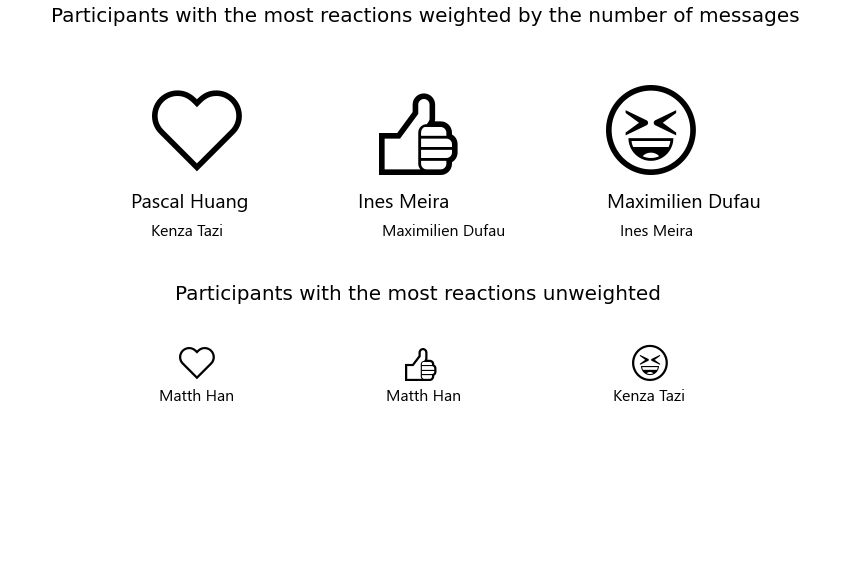

In [24]:
fig,ax = plt.subplots(figsize=(15,10))

yEmoji = 0.70
xFun = 0.25
xOffset = 0.21
emojiSize = 80
nameSize = 20
yOffset = 0.07
centeringOffset = 0.01
centeringOffset2 = 0.018
yMiniOffset = 0.038
name2Size = 16
ratioReducEmoji = 0.4
yEmoji2Offset = 0.3
nameGrossSize = 16

ax.text(xFun, yEmoji, '❤️', fontsize=emojiSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun + xOffset, yEmoji, '👍', fontsize=emojiSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun + 2*xOffset, yEmoji, '😆', fontsize=emojiSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun-centeringOffset, yEmoji-yOffset, ratioLove.loc[0,'messageSender'], fontsize=nameSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')
ax.text(xFun-centeringOffset+centeringOffset2, yEmoji-yOffset - yMiniOffset, ratioLove.loc[1,'messageSender'], fontsize=name2Size, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun-centeringOffset + xOffset, yEmoji-yOffset, ratioInformation.loc[0,'messageSender'], fontsize=nameSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')
ax.text(xFun-centeringOffset + xOffset+1.2*centeringOffset2, yEmoji-yOffset- yMiniOffset, ratioInformation.loc[1,'messageSender'], fontsize=name2Size, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun +centeringOffset + 2 * xOffset, yEmoji-yOffset, ratioFun.loc[0,'messageSender'], fontsize=nameSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')
ax.text(xFun +centeringOffset + 2 * xOffset+0.7*centeringOffset2, yEmoji-yOffset- yMiniOffset, ratioFun.loc[1,'messageSender'], fontsize=name2Size, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun+0.03, yEmoji-yEmoji2Offset, '❤️', fontsize=emojiSize*ratioReducEmoji, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')
ax.text(xFun+0.016, yEmoji-yEmoji2Offset-yMiniOffset, love.loc[0,'messageSender'], fontsize=nameGrossSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

plt.axis("off")
ax.text(xFun + xOffset+0.03, yEmoji-yEmoji2Offset, '👍', fontsize=emojiSize*ratioReducEmoji, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')
ax.text(xFun + xOffset+0.016, yEmoji-yEmoji2Offset-yMiniOffset, information.loc[0,'messageSender'], fontsize=nameGrossSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.text(xFun + 2*xOffset+0.03, yEmoji-yEmoji2Offset, '😆', fontsize=emojiSize*ratioReducEmoji, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')
ax.text(xFun + 2*xOffset+0.016, yEmoji-yEmoji2Offset-yMiniOffset, fun.loc[0,'messageSender'], fontsize=nameGrossSize, transform=plt.gcf(
    ).transFigure, fontproperties='Segoe UI Emoji')

ax.set_title("Participants with the most reactions weighted by the number of messages",size=20)
ax.text(0.20,0.5,"Participants with the most reactions unweighted",fontSize=20)

In [25]:
ratioInformation

,index,sender,messageIndex,reaction,reactionRatio,messageSender
0,Ines Meira,16,16,👍,0.432432,Ines Meira
1,Maximilien Dufau,11,11,👍,0.268293,Maximilien Dufau
2,Ewen Bernard,9,9,👍,0.257143,Ewen Bernard
3,Matth Han,51,51,👍,0.238318,Matth Han
4,Kétessar Tan,15,15,👍,0.200000,Kétessar Tan
5,Paul Meignan,9,9,👍,0.155172,Paul Meignan
6,Vincent Tran,8,8,👍,0.148148,Vincent Tran
7,Pascal Huang,5,5,👍,0.131579,Pascal Huang
8,Karis Gwet,5,5,👍,0.125000,Karis Gwet
9,Kenza Tazi,11,11,👍,0.065476,Kenza Tazi


In [26]:
df.head()

,index,sender,messageWordLength,type,messageCharacterLength,message,time,hour,dow,dom,date,emotion
0,1168,Maximilien Dufau,14,text,65,"Petit groupe de TD, go ajouter les gens que je...",2021-08-23 09:53:20.593,9,0,23,2021-08-23,Neutral
1,1167,Maximilien Dufau,8,text,37,Vous avez nommé le groupe DAI - 2023.,2021-08-23 09:53:43.386,9,0,23,2021-08-23,Neutral
2,1166,Charlotte Mauvezin,0,deleted,0,None,2021-08-23 09:56:21.300,9,0,23,2021-08-23,None
3,1165,Pascal Huang,0,deleted,0,None,2021-08-23 09:58:00.621,9,0,23,2021-08-23,None
4,1164,Kenza Tazi,0,sticker,0,None,2021-08-23 09:58:24.400,9,0,23,2021-08-23,None


In [27]:
print("Thread title: {}".format(threadInfo['title']))
print("Thread lifeTime: {} weeks".format(np.round(threadInfo['threadLifetime'],2)))
print("Number of messages: {}".format(df[df.type == "text"].shape[0]))
print("Number of images sent: {}".format(df[df.type == 'photo'].shape[0]))

Thread title: DAI - 2023
Thread lifeTime: 7.89 weeks
Number of messages: 1081
Number of images sent: 45


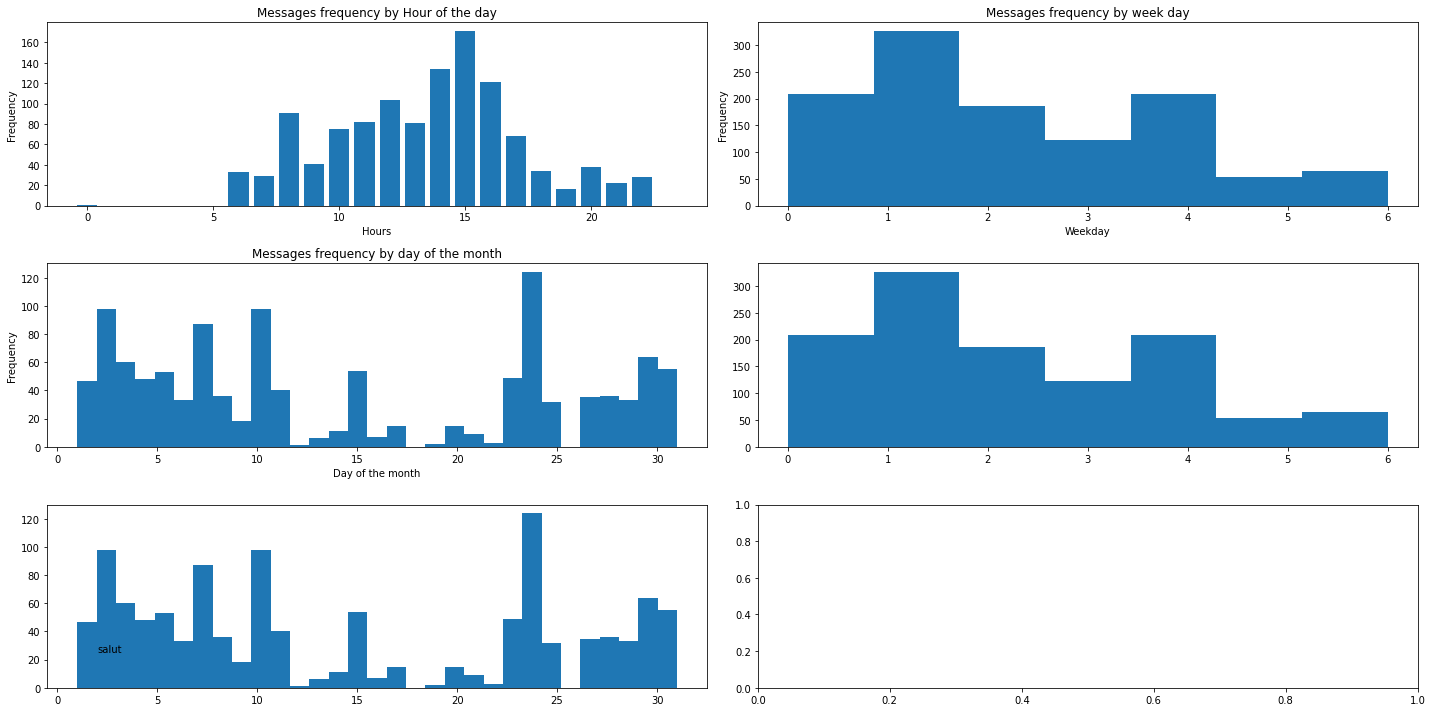

In [28]:
fig, axs = plt.subplots(3,2,figsize=(20, 10))
axs[0,0].hist(df[['hour']],bins=24,rwidth=0.8,range=(-0.5,23.5))
axs[0,1].hist(df['dow'],bins=7,range=(0,6))
axs[1,0].hist(df['dom'],bins=31,range=(1,31))
axs[1,1].hist(df['dow'],bins=7,range=(0,6))
axs[2,0].hist(df['dom'],bins=31,range=(1,31))
axs[2,0].text(2,25,"salut")
axs[0, 0].set(title = 'Messages frequency by Hour of the day',xlabel = "Hours",ylabel = "Frequency")
axs[0, 1].set(title = 'Messages frequency by week day',xlabel = "Weekday",ylabel = "Frequency")
axs[1,0].set(title='Messages frequency by day of the month',xlabel = "Day of the month",ylabel = "Frequency")
#axs[1, 1].set(title='Tip Amount Frequency',xlabel = "Tip amount ($)",ylabel = "Frequency")
#axs[2, 0].set(title='Passenger Number Frequency',xlabel = "Passenger Number",ylabel = "Frequency")
fig.tight_layout()

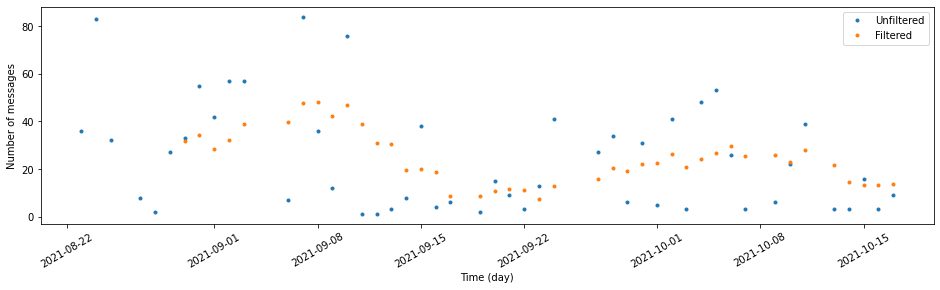

In [29]:
df1 = df[['date','sender']].groupby(['date']).count()

df1['filteredFrequency'] = df1['sender'].rolling(7).mean()


fig = plt.figure(figsize=(16,4))
plt.plot(df1,'.')
plt.gca().xaxis.set_tick_params(rotation=30,labelsize=10)
plt.legend(["Unfiltered","Filtered"])
plt.xlabel("Time (day)")
null = plt.ylabel("Number of messages")

In [30]:
dfGrouped.head()

,endTime,isSelfResponse,nbMessages,responseTime,sender,startTime
0,2021-08-23 09:53:43.386,0.0,2.0,0.000000,Maximilien Dufau,2021-08-23 09:53:20.593
1,2021-08-23 09:56:21.300,0.0,1.0,2.631900,Charlotte Mauvezin,2021-08-23 09:56:21.300
2,2021-08-23 09:58:00.621,0.0,1.0,1.655350,Pascal Huang,2021-08-23 09:58:00.621
3,2021-08-23 09:58:24.400,0.0,1.0,0.396317,Kenza Tazi,2021-08-23 09:58:24.400
4,2021-08-23 10:01:28.945,0.0,1.0,3.075750,Vincent Tran,2021-08-23 10:01:28.945


In [31]:
dfGrouped[dfGrouped.response_to_itself== True]

AttributeError: 'DataFrame' object has no attribute 'response_to_itself'

In [ ]:
dfGrouped.response_time.median()

In [ ]:
(df.loc[0,"time"]-df.loc[df.shape[0]-1,"time"])/ pd.Timedelta(minutes=1)

In [ ]:
emojiSet = {'😇','🤔','😘','🙂','😠','😒','🙃','👋','🥺','💃','👀','😏','🤷🏻','🥬','🐼','😬','😴','🥰','🤪','😋','👌','🙌','🤣','😍','😤','😁','😆','👍','🙄','❤️','😉','😮','🙈','😅','😂','🤓','😰','😊','🥵','😥','☺️','😆'}
#🤡
emojiCountDict= {i:0 for i in emojiSet}

df1 = df[df.type == "text"]
emojiColumn = []
for index,row in df.iterrows():
    emojiCount = 0
    if row.type == "text":
        for emoji in emojiSet:
            if emoji in row.message:
                emojiCountDict[emoji] +=1
                emojiCount += 1
    emojiColumn.append(emojiCount)
df["nbEmoji"] = emojiColumn

In [ ]:
def getEmojiCount(df,emojiSet):
    emojiCountDict= {i:0 for i in emojiSet}
    for index,row in df.iterrows():
        if row.type == "text":
            for emoji in emojiSet:
                if emoji in row.message:
                    emojiCountDict[emoji] +=1
    return emojiCountDict

df1 = pd.DataFrame(columns=emojiSet.add("Sender"))
df2 = df[['sender','message','type']].groupby(['sender']).apply(lambda x: getEmojiCount(x,emojiSet))
cpt = 0
for i in df2.index:
    df1 = df1.append(df2[i],ignore_index=True)
    df1.loc[cpt,"Sender"] = i
    cpt+=1

In [ ]:
df1 = pd.DataFrame(columns = {'sender','time','emoji'})
for index,row in df.iterrows():
    if row.type == "text":
        for emoji in emojiSet:
            for char in row.message.split():
                if emoji == char:
                    df1 = df1.append({'sender':row.sender,'time':row.time,'emoji':emoji},ignore_index=True)

In [ ]:
sns.set_style({'font.family':'Segoe UI Emoji', 'font.serif':['Times New Roman']})
df2 = df1.groupby(['sender','emoji']).apply(light_scaled_count_rows).unstack()
fig, ax = plt.subplots(figsize=(22,8))
sns.heatmap(df2, linewidths = .5,cmap = sns.color_palette("crest", as_cmap=True)).set(title='Scaled Distribution of sent emojis by senders');
sns.set(font_scale = 2)
null = plt.xticks(rotation=0)

In [ ]:
threadInfo

#### Sent emojis distribution

In [ ]:
df.head()

In [ ]:
def getEmojiCount(df,emojiSet):
    emojiCountDict= {i:0 for i in emojiSet}
    for index,row in df.iterrows():
        if row.type == "text":
            for emoji in emojiSet:
                if emoji in row.message:
                    emojiCountDict[emoji] +=1
    return emojiCountDict
a = getEmojiCount(df,emojiSet)
a = {k: v for k, v in sorted(a.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
dfSender = df[df.sender == "Kenza Tazi"]
dfSender = df[df.sender == "Matth Han"]
nbDeleted = dfSender[df.type == "deleted"].shape[0]
nbImages = dfSender[df.type == "photo"].shape[0]
meanWorldLength = dfSender.loc[dfSender.type == 'text',"messageWordLength"].mean()
meanWorldLength

In [ ]:
a = df.loc[df.type == "text",['messageWordLength','sender']].groupby('sender',as_index=False).mean().sort_values('messageWordLength',ascending=False,ignore_index=True)
a[a.sender == "Moise Iloo"].index[0]
a

In [ ]:
a = df.groupby('timeArea').mean().sort_values('nbEmoji',ascending=False)
a

In [ ]:
fig,ax = plt.subplots(1,figsize=(15,5))
ax.scatter(df['messageWordLength'],df['messageCharacterLength'])

In [ ]:
fig,ax = plt.subplots(1,figsize=(15,5))
ax.bar(a.index.to_list(),a['nbEmoji'].to_list())

In [ ]:
zone = {'Late Night (0-6)':[0,6],'Morning (6-10)': [6,10],'Noon (10-14)':[10,14],'Afternoon (14-18)':[14,18],'Evening (18-22)': [18,22],'Night (22-24)':[22,24]}
def getTimeArea(time,timeArea):
    for key in timeArea.keys():
        if time >= timeArea[key][0] and time < timeArea[key][1]:
            return key
    return None
df['timeArea'] = df['hour'].map(lambda x: getTimeArea(x,zone))
a = df.groupby('timeArea').count().sort_values('sender',ascending=False)

fig,ax = plt.subplots(1,figsize=(20,5))
ax.bar(a.index.to_list(),a['sender'].to_list())
ax.tick_params(axis='x', labelsize=20)

In [ ]:
df.loc[df.type == 'text','messageWordLength']

In [ ]:
df.loc[df.type == 'text','messageCharacterLength'].plot.hist(bins = 20 ,range=(0,100))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 10))


# PLOT 1
size = 0.3

cmap = plt.get_cmap("tab20c",lut=34)
outer_colors = cmap(([2*i for i in range(10)]))
inner_colors = cmap([1, 2, 5, 6, 9, 10])


df1 = df.groupby(['sender','emotion']).apply(count_rows).unstack()
df1 = df1[['Negative','Positive']]
df1 = df1.dropna()
npDf1 = df1.to_numpy()
explode1 = [0.025 for i in range(npDf1.sum(axis=1).shape[0])]
explode2 = [0.00 if i%2 != 0 else 0.0 for i in range(int(npDf1.sum(axis=1).shape[0]*2))]

patches1, texts = ax[0].pie(npDf1.sum(axis=1),colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),explode=explode1)

patches2, texts = ax[0].pie(npDf1.flatten(), radius=1-size, colors=[ '#61C585','#B45B47'],
       wedgeprops=dict(width=0.08, edgecolor='w'),explode = explode2)

ax[0].set(aspect="equal", title='Message Emotion grouped by senders')
ax[1].set(aspect="equal", title='General Statistics')
legendName =ax[0].legend(patches1,df1.index.to_list(),loc=1)
plt.axis('off')
legendEmotion = ax[0].legend(patches2,["Positive","Negative"],loc=4)
ax[0].add_artist(legendName)
#ax[0,0].add_artist(legendEmotion)


# PLOT 2

orderedEmojiCount = getEmojiCount(df,emojiSet)
orderedEmojiCount = {k: v for k, v in sorted(a.items(), key=lambda item: item[1], reverse=True)}

ax[1].text(0.57, 0.7, 'Most used emojis', fontsize=25, transform=plt.gcf().transFigure)

ax[1].text(0.58, 0.60, list(orderedEmojiCount.keys())[0] , fontsize=60, transform=plt.gcf().transFigure,fontproperties='Segoe UI Emoji')
ax[1].text(0.603, 0.55, '1th', fontsize=20, transform=plt.gcf().transFigure,fontproperties='Segoe UI Emoji')

ax[1].text(0.68, 0.60, list(orderedEmojiCount.keys())[1], fontsize=50, transform=plt.gcf().transFigure,fontproperties='Segoe UI Emoji')
ax[1].text(0.696, 0.55, '2nd', fontsize=20, transform=plt.gcf().transFigure,fontproperties='Segoe UI Emoji')

ax[1].text(0.78, 0.60, list(orderedEmojiCount.keys())[2], fontsize=40, transform=plt.gcf().transFigure,fontproperties='Segoe UI Emoji')
ax[1].text(0.794, 0.55, '3rd', fontsize=20, transform=plt.gcf().transFigure,fontproperties='Segoe UI Emoji')

ax[1].text(0.57, 0.47, threadInfo['nbMessages'] , fontsize=36, transform=plt.gcf().transFigure)
ax[1].text(0.595 + len(str(threadInfo['nbMessages']))/72, 0.47, 'messages sent' , fontsize=30, transform=plt.gcf().transFigure)

ax[1].text(0.57, 0.39, threadInfo['nbParticipants'] , fontsize=36, transform=plt.gcf().transFigure)
ax[1].text(0.595 + len(str(threadInfo['nbParticipants']))/72, 0.39, 'participants' , fontsize=30, transform=plt.gcf().transFigure)

fig.suptitle("{} thread summary".format(threadInfo['title']),y=0.88,fontsize=30)
plt.show()

In [ ]:
df1 = df.groupby(['sender','emotion']).apply(count_rows).unstack()
#df1 = df1[['Negative','Positive']]
#df1 = df1.dropna()
df1.fillna(0)

In [ ]:
df[['sender','messageWordLength']].groupby(['sender']).mean().to_numpy()

In [ ]:
df[['sender','messageWordLength']].groupby(['sender']).mean()

In [ ]:
fig = plt.figure(figsize=(20,5))

from matplotlib.font_manager import FontProperties
emojiCountDictPlot = {key:emojiCountDict[key] for key in emojiCountDict.keys() if emojiCountDict[key] != 0}

null = plt.bar(list(emojiCountDictPlot.keys()),list(emojiCountDictPlot.values()))
#fontname='Segoe UI Emoji'
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontproperties('Segoe UI Emoji')
plt.tick_params(labelsize = 20)
plt.title("Most used emojis")
plt.xlabel("Emojis")
null = plt.ylabel("Frequency")

#### Sent messages distribution

In [ ]:
df1 = df[['sender','message']].groupby(['sender']).count()
sns.set(rc={"figure.figsize":(16, 4)})
sns.barplot(x=df1.index,y = "message",data = df1 ).set(title='Number of messages sent')

In [ ]:
df1 = df.groupby(['sender', 'type']).apply(scaled_count_rows).unstack()
sns.heatmap(df1, linewidths = .5,cmap = sns.color_palette("crest", as_cmap=True)).set(title='Scaled Distribution of messages type by senders');

In [ ]:
df1 = df[['sender','nbEmoji']].groupby(['sender']).sum()
sns.barplot(x=df1.index,y = "nbEmoji",data = df1).set(title='Number of emojis')

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
chouCard = ["demain","très","quelle","tiens","vient","pris","passe","vas","ailleurs","voit","envoyer","pourquoi","vers","fin","courant","quelque","quel","tête","minutes","heure","mercredi","part","et","assez","pourra","mettre","mn","sors","dit","tous","partir","pars","autres","prendre","puis","gens","bonne","nuit","mangé","rien","fini","aimerais","finir","va","dur","prend","cours","passé","alors",'chose','autre','par','plutôt',"aujourd hui","encore","dire","trouvé","dis","mieux","plein","aujourd'hui",'tard','sais','fatigué','comment va','mal','commence','minute','comment','inquiète','inquiete','finalement','surtout','hier','sûr','contre','accord','veux','vais','demain']
ownSpecificWords = ['vraiment','pense','coup','https://','disponible sondage','disponible','https','déjà','truc','coup','juste','comme','être','donc','après','vrai','oui','dois','enfin','effet','moins','sinon','peux','parce','vu','non','fais','quand','aussi','trop','peu','avoir','autre','sans','jusqu']
ownStopWords = ['.','?','c\'est','ça','est','c',"J\'a",'w','j\'ai','où',':','cette','là','t','tout','l',"quoi",'j','ai','’','l’','j’ai','c’est','1','ca','fait','va','si','faut','peut','plus','j’','a','!','faire','bien',]
stopWords = stopwords.words('french')
stopWords = stopWords + ownStopWords + ownSpecificWords + chouCard
df1 = df[df.type == "text"]


text = (" ".join(df1['message'].to_list()))
text = re.sub(r'[\'`’?!]', " ", text)
text = text.split(" ")
filtered_text = [word for word in text if not word.lower() in stopWords]
filtered_text = " ".join(filtered_text) 

In [ ]:
word_cloud = WordCloud(normalize_plurals= False,stopwords= ['oui'], max_words = 160,colormap = 'cividis' ,min_font_size= 1,background_color="white",width=2500, height=1350,font_path='ressources/font/coolvetica rg.ttf').generate(filtered_text)
#wordcloud = WordCloud(background_color="white",max_words=len(s),max_font_size=40, relative_scaling=.5,font_path=font_path).generate(text)
fig = plt.figure(figsize=(19,19)) #'RdPu' 'cividis' 
plt.imshow(word_cloud)
plt.axis("off")
plt.show()
#word_cloud.to_file('card.png')

In [ ]:
filtered_text

In [ ]:
# [ ] Look into reactions
# [ ] Most popular emoji
# [ ] Warning, big conversation are splitted into multiples files
# [ ] Get temps de réponse (pour cela, regrouper message d'affilé des gens par paquets)
# [x] Number of sent images
# [x] See different type of messages, call should be in another DataFrame
# [ ] Graph of messages throught time with zero if no messages
# [x] Colonne nombre d'emojis
# [ ] Add an image classifier ?
# [x] Emoji count by person
# [x] Length of messages
# [x] Word cloud
# [ ] find emotion, with word embedding ?
# [ ] animated wordcloud depending on time of day
# [ ] Lematization
# [ ] Plot rather than text for general information, do it marketing style( add the top 3 most used emojis)
# [ ] Proper file upload
# [x] Analyser la conv de classe pour la présentation
# [x] For each stats at the end, plot le classement ( genre : 15 images envoyés (3eme))
# [ ] Export report as pdf 
# [ ] Warning when a lot of files
# [ ] Analyses cross-conversation
# [ ] Participant type : (ratio reaction/messages) + (ratio gif+images/messages) + (responsetime) + (ratio participation rate compared to median participation rate) + 
# [ ] Spider plot : Impact (quantité de réactions pondérée comparé au nombre médian) - Implication ( quantité messages, par rapport quantité réaction ) - Reactivité (temps de rép ) - Originalité (type de média, ) - exaustivité => for each give a note from 1 to 6 
# [ ] Create participant dataFrame with : name | responseTime | nbEMoji | nbMessage | nbImages | nbUnsent | nbGif | Top 3 favorite Emoji | abreviationUsageRate | positivityRate
# [ ] Les inactifs sabotents les stats, il faut les retirer des stats
# [ ] Reactivity should be penalized by the fact of not responding at all
# [ ] Graph of reaction
# missingno

In [ ]:
data

In [ ]:
dfReactions[dfReactions.messageSender == 'Pascal Huang']

In [ ]:
#Goes from 1 to 6, Swiss notation <3

def getInRange(value,bornInf=1,bornSup=6):
    ''' Guarantee that in the end, value is forced to be in a certain interval '''
    return min(max(bornInf,value),bornSup)

def sigmoid(x,multiScale=1,offset=0):
    return 1/(1+ np.exp(-(x+offset)*multiScale))

def grade(value,bornInf=1,bornSup=6,multiScale=1,offset = 0):
    return bornInf + (bornSup-bornInf)*sigmoid(value,multiScale=multiScale,offset = offset)

sender = 'Maximilien Dufau'
sender = 'Charlotte Mauvezin'
dfSender = df[df.sender == sender]
# We always compare too the median because mean can be quite bad in conversation with loads of members
#
# IMPACT : How much your message raise reaction and create activity in the conversation ?

receivedReactionRatio = dfReactions[dfReactions.messageSender==sender].shape[0]/dfReactions.groupby('messageSender').count()['sender'].median()

impact = grade(receivedReactionRatio, multiScale = 1.2,offset = -1)

# ENGAGEMENT : How often and importantly do you participate in the discussion ?

#DEV : To implement summed fonction, we need to be able to compare the result of the sum to the other participant results, this code architecture is not suitable for that rn

sentReactionsRatio = dfReactions[dfReactions.sender==sender].shape[0]/dfReactions.groupby('sender').count()['messageSender'].median()
sentMessagesRatio = dfSender.shape[0]/df.shape[0]

wordVolumeByParticipant = df.groupby('sender').sum().messageWordLength
wordVolumeRatio = wordVolumeByParticipant[sender]/wordVolumeByParticipant.median()

engagement = sentMessagesRatio
engagement =  grade(engagement, multiScale = 12,offset = -1/threadInfo['nbParticipants'])
engagement = grade(wordVolumeRatio, multiScale = 8,offset = -1)



# REACTIVITY : How fast are you to respond ?
responseTimeBySender = dfGrouped[dfGrouped.responseTime <= dfGrouped.responseTime.quantile(0.95)].groupby('sender').median()['responseTime']

responseTimeRatio = (responseTimeBySender[responseTimeBySender.index==sender].to_numpy()[0])/(responseTimeBySender.median())

reactivity = grade(responseTimeRatio, multiScale = -4,offset = -1) # answer slowly (high response time) is penalized here, so the multiscale is negative



# ORIGINALITY : Are you the impostor ?
# To implement
originality = 0




total = np.mean(impact + engagement + reactivity + originality)

In [ ]:
import plotly.express as px
import pandas as pd
import plotly as py
df1 = pd.DataFrame(dict(
    r=[impact,reactivity,engagement],
    theta=['impact','reactivity','engagement']))

fig = px.line_polar(df1, r='r', theta='theta', line_close=True,range_r =[0,6],title='Participant fingerprint',line_shape = 'spline')

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.update_traces(fill='toself')

In [ ]:
dfGrouped[dfGrouped.responseTime <= dfGrouped.responseTime.quantile(0.95)].groupby('sender').mean()['responseTime']

In [ ]:
df.groupby('sender').sum()

In [ ]:
a = df.groupby('sender').sum().messageWordLength
a['Charlotte Debras']/a.median()

In [ ]:
a = sentMessagesRatio
b = (a-1)*2
print(a, '(a)')
print(b, '(tranformed a)')
print(sigmoid(a,multiScale = 1,offset = -1/threadInfo['nbParticipants']))
grade(a, multiScale = 8,offset = -1/threadInfo['nbParticipants'])

In [ ]:
dfReactions[dfReactions.sender==sender].shape[0]/dfReactions.groupby('sender').count()['messageSender'].median()

In [ ]:
a = (responseTimeBySender[responseTimeBySender.index==sender].to_numpy()[0])/(responseTimeBySender.median())
print(a)
grade(a, multiScale = -4,offset = -1)

In [ ]:
(a.loc[a.index==sender,'responseTime'].to_numpy()[0])/(a.responseTime.mean())

In [ ]:
a.loc[a.index==sender,'responseTime'].to_numpy()[0]

In [ ]:
dfGrouped[dfGrouped.sender == 'Matth Han'].responseTime.median()

In [ ]:
dfGrouped[dfGrouped.sender == 'Maximilien Dufau'].responseTime.median()

In [ ]:
    df1 = dfReactions.groupby(['messageSender', 'reaction']).count()
    df1['reaction'] = df1.index.map(lambda x: x[1])
    df1.index = df1.index.map(lambda x: x[0])
    df2 = df[['sender', 'time']].groupby('sender', as_index=False).count()
    df1['reactionRatio'] = df1.apply(
        lambda x: x.messageIndex/int(df2.loc[df2.sender == x.name, 'time']), axis=1)
    df1[df1.reaction == '👍']
    df1 = df1.drop(
        index=df2[df2.time/threadInfo['threadLifetime'] < 4].sender, errors='ignore')
    df1['messageSender'] = df1.index
    df1 = df1.reset_index()
    fun = df1[df1.reaction == '😆'].sort_values(
        by=['sender'], ascending=False, ignore_index=True)
    love = df1[df1.reaction == '❤'].sort_values(
        by=['sender'], ascending=False, ignore_index=True)
    information = df1[df1.reaction == '👍'].sort_values(
        by=['sender'], ascending=False, ignore_index=True)
    ratioFun = fun.sort_values(
        by=['reactionRatio'], ascending=False, ignore_index=True)
    ratioLove = love.sort_values(
        by=['reactionRatio'], ascending=False, ignore_index=True)
    ratioInformation = information.sort_values(
        by=['reactionRatio'], ascending=False, ignore_index=True)

In [ ]:
ratioLove

In [ ]:
ratioInformation

In [ ]:
df[df.sender=='Pascal Huang']

In [77]:
import networkx as nx

g = nx.DiGraph()
a = np.unique(list(set.union(set(dfReactions.sender.to_list()),set(dfReactions.messageSender.to_list()))))

In [78]:
g.add_nodes_from(a)

In [79]:
b = dfReactions.groupby(['sender','messageSender']).count()

In [94]:
b.messageIndex.shape
len(list(g.edges))

209

In [81]:
l = []
for index, row in b.iterrows():
    l.append((index[1],index[0],row['messageIndex']))

In [82]:
g.add_weighted_edges_from(l)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


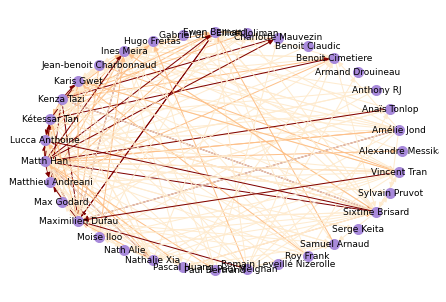

<Figure size 2880x2880 with 0 Axes>

In [170]:
seed = 15344 
pos = nx.circular_layout(g)
nx.draw(g, pos, with_labels=True,node_size = 100,node_color = (0.66, 0.54, 0.86), font_size = 9, edge_color = [cm.OrRd(g.edges[i]['weight']**6+25)[0:3] for i in g.edges])
plt.figure(3,figsize=(40,40)) 
plt.show()

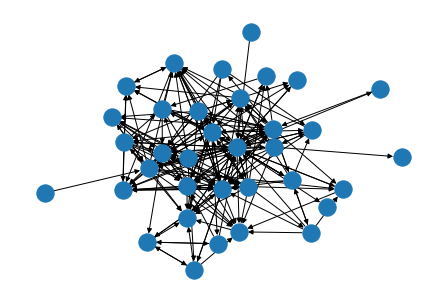

In [119]:
nx.draw_kamada_kawai(g)
plt.show()

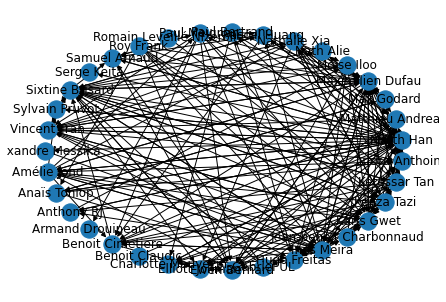

In [86]:
nx.draw_shell(g,with_labels=True)
plt.show()

In [122]:
c = plt.get_cmap('viridis')

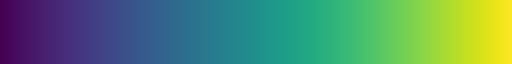

In [123]:
c

In [125]:
type(c)

matplotlib.colors.ListedColormap

In [131]:
from matplotlib import cm
cm.viridis(300)[0:3]

(0.993248, 0.906157, 0.143936)

[(0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.272594, 0.025563, 0.353093),
 (0.277941, 0.056324, 0.381191),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.272594, 0.025563, 0.353093),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.26851, 0.009605, 0.335427),
 (0.272594, 0.025563, 0.353093),
 (0.272594, 0.025563, 0.353093),
 (0.272594, 0.025563, 0.353093),
 (

In [159]:
245/255, 241/255, 221/255

(0.9607843137254902, 0.9450980392156862, 0.8666666666666667)

In [2]:
600/30

20.0